In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 380 (delta 117), reused 97 (delta 67), pack-reused 171
Receiving objects: 100% (380/380), 55.95 MiB | 30.87 MiB/s, done.
Resolving deltas: 100% (178/178), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=221e45fbc131ca64fc972f78248efa8886b43884fc99248133b4c81cf4aebc46
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgzynmfw/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
from typing import Set, Union, Tuple, List
from tqdm.notebook import tqdm, trange

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


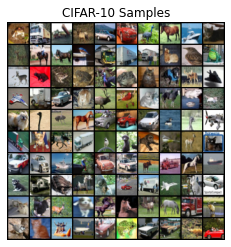

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [ ]:
from typing import Set, Union, Tuple, List
from tqdm.notebook import tqdm, trange

import numpy 
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size: int):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size: int):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


class UpsampleConv2d(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, 
                 kernel_size: Tuple[int, int] = (3, 3), 
                 stride: int = 1, padding: int = 1, bias: bool = True):
        super().__init__()
        self.depth_to_space = DepthToSpace(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = torch.cat([x, x, x, x], dim=1)
        out = self.depth_to_space(out)
        out = self.conv(out)
        return out


class DownsampleConv2d(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, 
                 kernel_size: Tuple[int, int] = (3, 3), 
                 stride: int = 1, padding: int = 1, bias: bool = True):
        super().__init__()
        self.space_to_depth = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.space_to_depth(x)
        out = sum(out.chunk(4, dim=1)) / 4.0
        out = self.conv(out)
        return out


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim: int, 
                 kernel_size: Tuple[int, int] = (3, 3), 
                 n_filters: int = 128):
        super().__init__()
        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            UpsampleConv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.shortcut = UpsampleConv2d(in_dim, n_filters, 
                                       kernel_size=(1, 1), padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.residual(x)
        sh = self.shortcut(x)
        return res + sh


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim: int, 
                 kernel_size: Tuple[int, int] = (3, 3), 
                 stride: int = 1, n_filters: int = 128):
        super().__init__()
        self.residual = nn.Sequential(
            nn.ReLU(), 
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
            nn.ReLU(), 
            DownsampleConv2d(n_filters, n_filters, kernel_size))
        
        self.shortcut = DownsampleConv2d(in_dim, n_filters, kernel_size=(1, 1), 
                                         padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.residual(x)
        sh = self.shortcut(x)
        return res + sh


class Generator(nn.Module):
    def __init__(self, n_filters: int = 128):
        super().__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        self.model = nn.Sequential(            
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh())
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.model(z)

    def sample(self, n_samples: int) -> torch.Tensor:
        z = self.noise.sample([n_samples, 128]).to(device)
        return self(z)


class Discriminator(nn.Module):
    def __init__(self, n_filters: int = 128):
        super().__init__()
        self.model = nn.Sequential(
            ResnetBlockDown(in_dim=3, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            nn.ReLU())
        self.fc = nn.Linear(128, 1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        out = self.model(z)
        out = torch.sum(out, dim=(2, 3))
        return self.fc(out)

In [ ]:
class GAN: 
    def __init__(self, n_filters: int = 128): 
        self.g = Generator(n_filters).to(device)
        self.d = Discriminator(n_filters).to(device)

        self.n_critic = 5

    def _optimizer(self, model): 
        return optim.Adam(model.parameters(), lr=2e-4, betas=(0., 0.9))

    def _scheduler(self, optimizer, epochs: int): 
        return optim.lr_scheduler.LambdaLR(optimizer, 
                                           lambda epoch: (epochs - epoch) / epochs, 
                                           last_epoch=-1)
        
    def _grad_penalty(self, real_data: torch.Tensor, fake_data: torch.Tensor) -> torch.Tensor: 
        batch_size = len(real_data)
        eps = torch.rand(batch_size, 1, 1, 1).to(device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                        grad_outputs=torch.ones(d_output.size()).to(device),
                                        create_graph=True, retain_graph=True)[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12).to(device)
        return ((gradients_norm - 1) ** 2).mean()

    def _d_update(self, real_data: torch.Tensor, optimizer) -> torch.Tensor: 
        optimizer.zero_grad()
        fake_data = self.g.sample(len(real_data))

        grad_penalty = self._grad_penalty(real_data, fake_data)
        loss = self.d(fake_data).mean() - self.d(real_data).mean() + 10 * grad_penalty
        loss.backward()

        optimizer.step()
        return loss

    def _g_update(self, real_data: torch.Tensor, optimizer) -> torch.Tensor: 
        optimizer.zero_grad()
        fake_data = self.g.sample(len(real_data))
        loss = -self.d(fake_data).mean()
        loss.backward()
        optimizer.step()
        return loss

    def train(self, train_data: np.ndarray, 
              n_iterations: int = 25_000, batch_size: int = 256) -> np.ndarray:
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        epochs = n_iterations // len(train_loader) 

        g_optimizer, d_optimizer = self._optimizer(self.g), self._optimizer(self.d)
        g_scheduler, d_scheduler = self._scheduler(g_optimizer, epochs), self._scheduler(d_optimizer, epochs)

        train_losses, curr_iter = [], 0

        for _ in trange(epochs, desc="Epochs"): 
            self.g.train()
            self.d.train()

            batch_losses = []
            for real_data in train_loader:
                curr_iter += 1

                real_data = real_data.float().to(device)
                self._d_update(real_data, d_optimizer)
                if curr_iter % self.n_critic == 0:
                    loss = self._g_update(real_data, g_optimizer)
                    batch_losses.append(loss.cpu().detach().item())

            g_scheduler.step()
            d_scheduler.step()
            train_losses.append(np.mean(batch_losses))

        return np.array(train_losses)

    def sample(self, n: int) -> np.ndarray: 
        self.g.eval()
        with torch.no_grad():
            samples = self.g.sample(1000)

        return samples.cpu().detach().numpy()

In [ ]:
def transform_images(images: np.ndarray) -> np.ndarray: 
    images = 2 * images - 1
    return images

def inv_transform_images(images: np.ndarray) -> np.ndarray: 
    images = 0.5 * images + 0.5
    images = images.transpose(0, 2, 3, 1)
    return images

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    gan = GAN(n_filters=128)
    losses = gan.train(transform_images(train_data), 
                       n_iterations=5_000, batch_size=256)
    samples = inv_transform_images(gan.sample(1_000))
    return losses, samples

## Results

In [ ]:
q1_save_results(q1)

Files already downloaded and verified


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Files already downloaded and verified


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

..........Inception score: 2.4528294


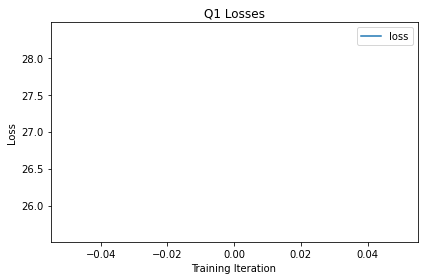

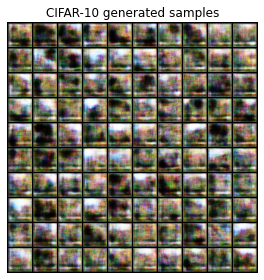

In [ ]:
q1_save_results(q1)

Files already downloaded and verified


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

..........Inception score: 1.000006


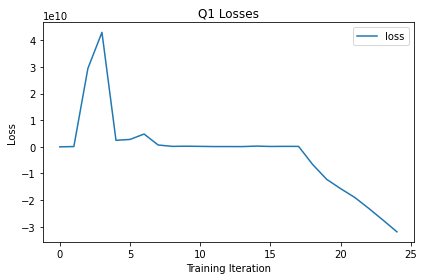

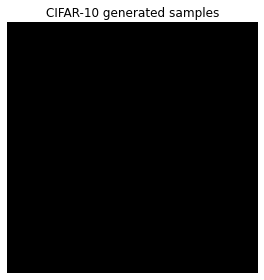

In [ ]:
q1_save_results(q1)

Files already downloaded and verified



..........Inception score: 6.062043


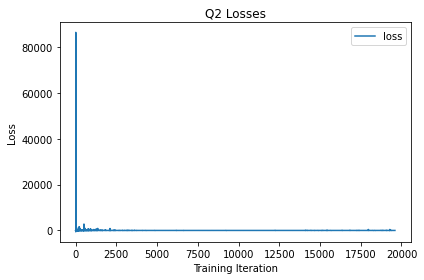

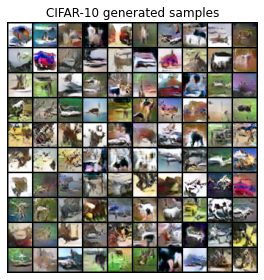

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


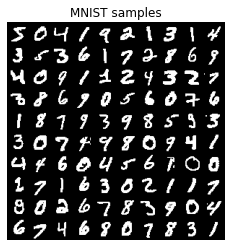

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x).view(len(x), 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, z_dim: int, x_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        cat = torch.cat((z, x), dim=1)
        return self.model(cat)


class Encoder(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(len(x), -1)
        return self.model(x)

In [ ]:
class BiGAN: 
    def __init__(self, latent_dim: int = 50): 
        self.latent_dim = latent_dim
        self.reset_gan(latent_dim)
        self.reset_classifier(latent_dim)

    def reset_gan(self, latent_dim: int): 
        self.d = Discriminator(latent_dim, 28 * 28).to(device)
        self.g = Generator(latent_dim).to(device)
        self.e = Encoder(28 * 28, latent_dim).to(device)

    def reset_classifier(self, latent_dim: int):
        self.classifier = nn.Linear(latent_dim, 10).to(device)

    def reset_gan_optimizers(self, epochs: int):
        self.d_optimizer = optim.Adam(self.d.parameters(), lr=2e-4, 
                                      betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_optimizer = optim.Adam(list(self.e.parameters()) + list(self.g.parameters()), 
                                      lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        
        self.d_scheduler = optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                       lambda epoch: (epochs - epoch) / epochs,
                                                       last_epoch=-1)
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (epochs - epoch) / epochs,
                                                             last_epoch=-1)

    def reset_classifier_optimizers(self): 
        self.classifier_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

    def train(self, mode: bool): 
        self.d.train(mode)
        self.g.train(mode)
        self.e.train(mode)
        self.classifier.train(mode)

    def _loss(self, x: torch.Tensor) -> torch.Tensor: 
        z_fake = torch.normal(torch.zeros(len(x), self.latent_dim), torch.ones(len(x), self.latent_dim)).to(device)
        z_real = self.e(x).reshape(len(x), self.latent_dim)

        x_fake = self.g(z_fake).reshape(len(x), -1)
        x_real = x.view(len(x), -1)

        loss = -0.5 * (self.d(z_real, x_real)).log().mean() - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return loss

    def eval_model(self, data_loader) -> List[float]: 
        self.train(False)

        losses = []
        with torch.no_grad(): 
            for (x, _) in data_loader: 
                x = x.to(device)
                loss = self._loss(x)
                losses.append(loss.item())

        return losses
        
    def train_model(self, train_data, test_data, 
                    epochs: int = 100, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray]: 
        self.reset_gan_optimizers(epochs)

        train_loader = data.DataLoader(train_data, batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size, shuffle=False)

        train_losses, test_losses = [], []

        for _ in trange(epochs, desc="BiGAN epoch"): 
            self.train(True)

            batch_losses = []

            for (x, _) in tqdm(train_loader, desc="Batch", leave=False): 
                x = x.to(device)

                self.d_optimizer.zero_grad()
                d_loss = self._loss(x)
                d_loss.backward()
                self.d_optimizer.step()

                self.g_optimizer.zero_grad() 
                g_loss = -self._loss(x)
                g_loss.backward()
                self.g_optimizer.step()

                batch_losses.append(d_loss.item())

            self.d_scheduler.step()
            self.g_scheduler.step() 

            train_losses.extend(batch_losses)
            test_losses.extend(self.eval_model(test_loader))

        return np.array(train_losses), np.array(test_losses)

    def eval_classifier(self, data_loader) -> float: 
        self.train(False)

        total_loss = n_items = 0
        with torch.no_grad(): 
            for (x, y) in data_loader: 
                x = x.to(device)
                y = y.to(device)

                pred = self.classifier(self.e(x).detach())
                loss = F.cross_entropy(pred, y)

                total_loss += loss.item() * len(x)
                n_items += len(x)

        return total_loss / n_items

    def train_classifier(self, train_data, test_data, 
                         epochs: int = 20, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray]: 
        self.reset_classifier_optimizers()
                  
        train_loader = data.DataLoader(train_data, batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size, shuffle=False) 

        train_losses, test_losses = [], []

        for _ in trange(epochs, desc="Classifier epoch"):
            self.train(False)
            self.classifier.train()

            total_loss = n_items = 0

            for (x, y) in tqdm(train_loader, desc="Batch", leave=False): 
                x = x.to(device)
                y = y.to(device)

                self.classifier_optimizer.zero_grad()
                pred = self.classifier(self.e(x).detach())
                loss = F.cross_entropy(pred, y)
                loss.backward()
                self.classifier_optimizer.step()

                total_loss += loss.item() 
                n_items += len(x)

            train_losses.append(total_loss / n_items)
            test_losses.append(self.eval_classifier(test_loader))

        return np.array(train_losses), np.array(test_losses)
    
    def sample(self, n: int) -> np.ndarray: 
        self.g.eval()

        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(n, 1, 28, 28)
        return samples.cpu().detach().numpy()

    def reconstructions(self, x: np.ndarray) -> np.ndarray: 
        self.g.eval()
        self.e.eval()

        with torch.no_grad():
            x = torch.tensor(x, device=device)
            z = self.e(x)
            recons = self.g(z).reshape(-1, 1, 28, 28)
        return recons.cpu().detach().numpy()

## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    model = BiGAN(latent_dim=50)

    train_class_losses, test_class_losses = model.train_classifier(train_data, test_data, epochs=20)
    train_gan_losses, test_gan_losses = model.train_model(train_data, test_data, epochs=100)
    samples = model.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5

    train_images = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    recons = model.reconstructions(train_images * 2 - 1) * 0.5 + 0.5
    recons = np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1)

    model.reset_classifier(latent_dim=50)
    train_class_losses_post, test_class_losses_post = model.train_classifier(train_data, test_data,  epochs=20)

    return test_gan_losses, samples, recons, test_class_losses_post, test_class_losses

## Results

Classifier epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

BiGAN epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Classifier epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

Batch:   0%|          | 0/469 [00:00<?, ?it/s]

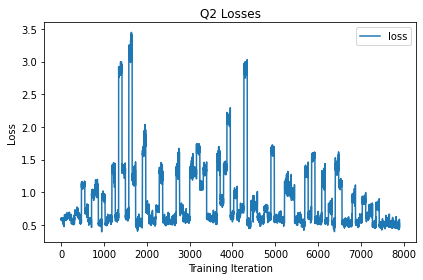

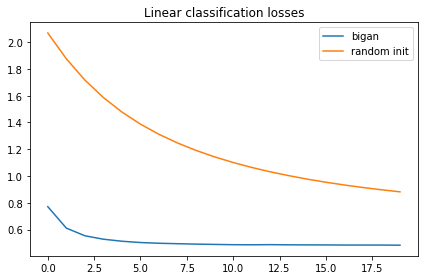

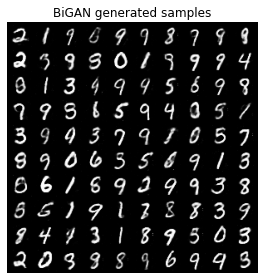

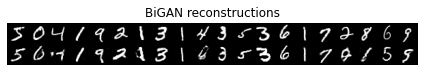

BiGAN final linear classification loss: 0.48319643092155456
Random encoder linear classification loss: 0.8818863173484802


In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

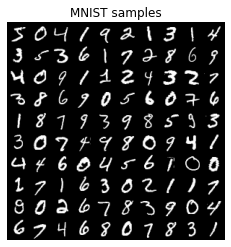

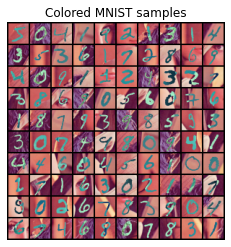

In [5]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [6]:
class Generator(nn.Module): 
    def __init__(self, in_channels: int, out_channels: int): 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1), # -> 32 x 14 x 14 
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(), 
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # -> 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(), 
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> 64 x 7 x 7 
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(), 
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # -> 128 x 8 x 8 
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 64 x 16 x 16
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(), 
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> 32 x 32 x 32
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(), 
            nn.Conv2d(32, 16, kernel_size=3, padding=0, stride=1),  # -> 16 x 30 x 32
            nn.BatchNorm2d(16),
            nn.LeakyReLU(), 
            nn.Conv2d(16, out_channels, kernel_size=3, padding=0, stride=1),  # -> out_channels x 28 x 28
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        out = self.encoder(x)
        out = out.view(len(x), 128, 4, 4)
        out = self.decoder(out)
        return out


class Discriminator(nn.Module): 
    def __init__(self, in_channels: int): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1), # -> 32 x 14 x 14 
            nn.LeakyReLU(), 
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # -> 32 x 14 x 14
            nn.LeakyReLU(), 
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> 64 x 7 x 7 
            nn.LeakyReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), # -> 64 x 4 x 4
            nn.LeakyReLU(), 
            nn.Flatten(), 
            nn.Linear(64 * 4 * 4, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        # x.shape = (batch_size, in_channels, 28, 28)
        return self.model(x)

In [7]:
class CustomDataset(data.Dataset):
    def __init__(self, x_data: np.ndarray, y_data: np.ndarray): 
        super().__init__()
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]: 
        return self.x_data[index], self.y_data[index]
 
    def __len__(self) -> int:
        return len(self.x_data)

In [8]:
class Buffer: 
    def __init__(self, buffer_size: int): 
        self.buffer_size = buffer_size
        self.samples = []

    def add(self, samples: torch.Tensor): 
        self.samples = [sample for sample in samples.detach().cpu()] + self.samples
        self.samples = self.samples[:self.buffer_size]

    def sample(self, size: int) -> torch.Tensor: 
        indexes = np.random.choice(len(self.samples), size=size, replace=False)
        samples = torch.cat([self.samples[i].unsqueeze(0) for i in indexes], dim=0).to(device)
        return samples

In [9]:
class CycleGAN(nn.Module): 
    def __init__(self, x_channels: int, y_channels: int): 
        super().__init__()
        self.G = Generator(x_channels, y_channels)
        self.F = Generator(y_channels, x_channels)

        self.D_x = Discriminator(x_channels)
        self.D_y = Discriminator(y_channels)

        self.x_buffer = Buffer(buffer_size=50)
        self.y_buffer = Buffer(buffer_size=50)

        self.lambd = 10
        self.batch_size = None

    def gen_loss(self, 
                 x: torch.Tensor, 
                 y: torch.Tensor) -> torch.Tensor: 
        y_gen = self.G(x)
        x_gen = self.F(y)

        self.y_buffer.add(y_gen)
        self.x_buffer.add(x_gen)

        loss_1 = self.D_y(y_gen).sub_(1).pow_(2).mean()
        loss_2 = self.D_x(x_gen).sub_(1).pow_(2).mean()
        loss_3 = (self.F(y_gen) - x).abs_().mean() + (self.G(x_gen) - y).abs_().mean()
        loss = loss_1 + loss_2 + self.lambd * loss_3
        return loss

    def dis_loss(self, 
                 x: torch.Tensor, 
                 y: torch.Tensor) -> torch.Tensor: 
        y_gen = self.y_buffer.sample(self.batch_size)
        x_gen = self.x_buffer.sample(self.batch_size)

        loss_1 = self.D_x(x).sub_(1).pow_(2).mean() + self.D_x(x_gen).pow_(2).mean()
        loss_2 = self.D_y(y).sub_(1).pow_(2).mean() + self.D_y(y_gen).pow_(2).mean()
        loss = loss_1 + loss_2
        return loss

    def fit(self, 
            dataset: data.Dataset, 
            batch_size: int = 1, 
            lr: float = 2e-4,
            epochs: int = 20) -> Tuple[np.ndarray, ...]: 
        self.train()
        self.batch_size = batch_size
        data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        gen_opt = optim.Adam(list(self.G.parameters()) + list(self.F.parameters()))
        dis_opt = optim.Adam(list(self.D_x.parameters()) + list(self.D_y.parameters()))

        for epoch in trange(epochs, desc="Epoch"): 
            # for (x, y) in tqdm(data_loader, desc="Iter", leave=False): 
            for (x, y) in data_loader: 
                x = x.float().to(device)
                y = y.float().to(device)

                gen_loss = self.gen_loss(x, y)
                gen_opt.zero_grad()
                gen_loss.backward()
                gen_opt.step() 

                dis_loss = self.dis_loss(x, y)
                dis_opt.zero_grad()
                dis_loss.backward()
                dis_opt.step() 

    def translate(self,
                  data: np.ndarray, 
                  frm: str) -> np.ndarray: 
        self.eval()
        data = torch.tensor(data, dtype=torch.float, device=device)
        with torch.no_grad(): 
            if frm == "x": 
                out = self.G(data)
            elif frm == "y": 
                out = self.F(data)
            else: 
                raise ValueError(f"Unknown translation frm '{frm}'")
        out = out.detach().cpu().numpy()
        return out

    def reconstruct(self, 
                    data: np.ndarray, 
                    frm: str) -> np.ndarray: 
        self.eval()
        data = torch.tensor(data, dtype=torch.float, device=device)
        with torch.no_grad():
            if frm == "x": 
                out = self.F(self.G(data))
            elif frm == "y": 
                out = self.G(self.F(data))
            else: 
                raise ValueError(f"Unknown reconstruction from '{frm}'")
        out = out.detach().cpu().numpy()
        return out

In [10]:
def tr_images(x: np.ndarray) -> np.ndarray: 
    # [0, 1] -> [-1, 1]
    return 2 * x - 1

def inv_tr_images(x: np.ndarray) -> np.ndarray: 
    # [-1, 1] -> [0, 1]
    return 0.5 * x + 0.5

In [11]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """

    mnist_data_tr, cmnist_data_tr = tr_images(mnist_data), tr_images(cmnist_data)
    dataset = CustomDataset(mnist_data_tr, cmnist_data_tr) 
    model = CycleGAN(x_channels=1, y_channels=3).to(device)
    model.fit(dataset, epochs=1)

    size = 20
    mnist_real = mnist_data[np.random.choice(len(mnist_data), size=size, replace=False)]
    mnist_translated = model.translate(tr_images(mnist_real), frm="x")
    mnist_translated = inv_tr_images(mnist_translated).transpose(0, 2, 3, 1)
    mnist_reconstructed = model.reconstruct(tr_images(mnist_real), frm="x")
    mnist_reconstructed = inv_tr_images(mnist_reconstructed).transpose(0, 2, 3, 1)
    mnist_real = mnist_real.transpose(0, 2, 3, 1)

    cmnist_real = cmnist_data[np.random.choice(len(cmnist_data), size=size, replace=False)]
    cmnist_translated = model.translate(tr_images(cmnist_real), frm="y")
    cmnist_translated = inv_tr_images(cmnist_translated).transpose(0, 2, 3, 1)
    cmnist_reconstructed = model.reconstruct(tr_images(cmnist_real), frm="y")
    cmnist_reconstructed = inv_tr_images(cmnist_reconstructed).transpose(0, 2, 3, 1)
    cmnist_real = cmnist_real.transpose(0, 2, 3, 1)

    return mnist_real, mnist_translated, mnist_reconstructed, cmnist_real, cmnist_translated, cmnist_reconstructed

## Results

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

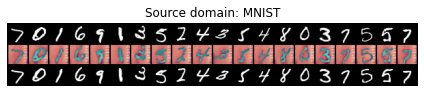

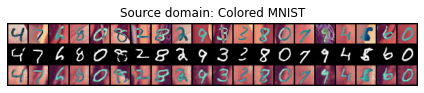

In [12]:
b5_save_results(b5)

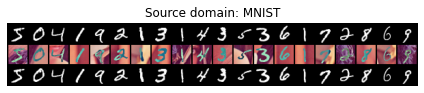

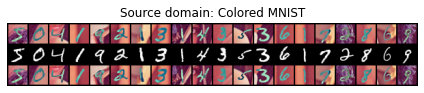

In [ ]:
# Результаты Фарида
b5_save_results(b5)